In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import ClusterCentroids , NearMiss

from tqdm.notebook import tqdm ,tnrange

/kaggle/input/healthcareanalyticsii/train.csv
/kaggle/input/healthcareanalyticsii/train_data_dict.csv
/kaggle/input/healthcareanalyticsii/test.csv
/kaggle/input/healthcareanalyticsii/sample_submission.csv
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/__results__.html
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/__output__.json
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/custom.css
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/__notebook__.ipynb
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/combined.csv


In [2]:
train_data = pd.read_csv('../input/healthcareanalyticsii/train.csv')
test_data = pd.read_csv('../input/healthcareanalyticsii/test.csv')

In [3]:
print(train_data.shape)
train_data.head()

(318438, 18)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [4]:
print(test_data.shape)
test_data.head()

(137057, 17)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,318440,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,318442,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,318443,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


In [5]:
def nullColumns(train_data):
    list_of_nullcolumns =[]
    for column in train_data.columns:
        total= train_data[column].isna().sum()
        try:
            if total !=0:
                print('Total Na values is {0} for column {1}' .format(total, column))
                list_of_nullcolumns.append(column)
        except:
            print(column,"-----",total)
    print('\n')
    return list_of_nullcolumns


def percentMissingFeature(data):
    data_na = (data.isnull().sum() / len(data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return data_na


def plotMissingFeature(data_na):
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    if(data_na.empty ==False):
        sns.barplot(x=data_na.index, y=data_na)
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)

In [6]:
print('train data')
print(nullColumns(train_data))
print(percentMissingFeature(train_data))
print('\n')
print('test_data')
print(nullColumns(test_data))
print(percentMissingFeature(test_data))

train data
Total Na values is 113 for column Bed Grade
Total Na values is 4532 for column City_Code_Patient


['Bed Grade', 'City_Code_Patient']
City_Code_Patient    1.423197
Bed Grade            0.035486
dtype: float64


test_data
Total Na values is 35 for column Bed Grade
Total Na values is 2157 for column City_Code_Patient


['Bed Grade', 'City_Code_Patient']
City_Code_Patient    1.573798
Bed Grade            0.025537
dtype: float64


Text(0.5, 1.0, 'Stay')

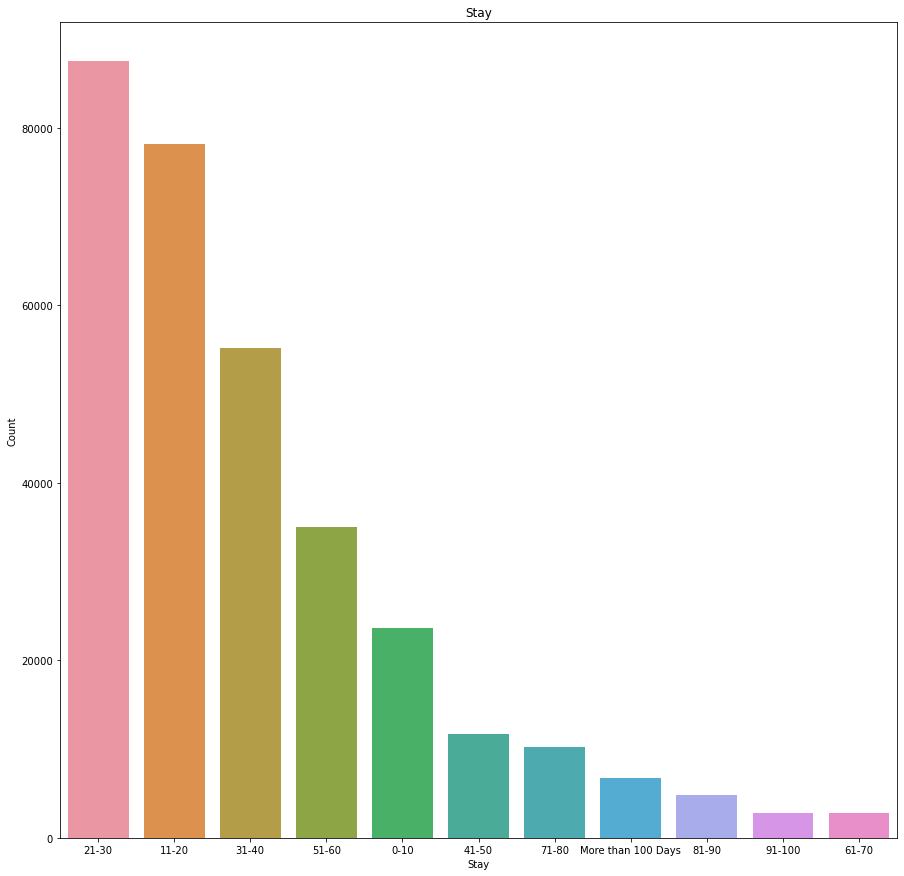

In [7]:
stay = train_data.loc[:,"Stay"].value_counts().rename('Count')
plt.xlabel("Stay")
plt.ylabel('Count')
sns.barplot(stay.index , stay.values).set_title('Stay')

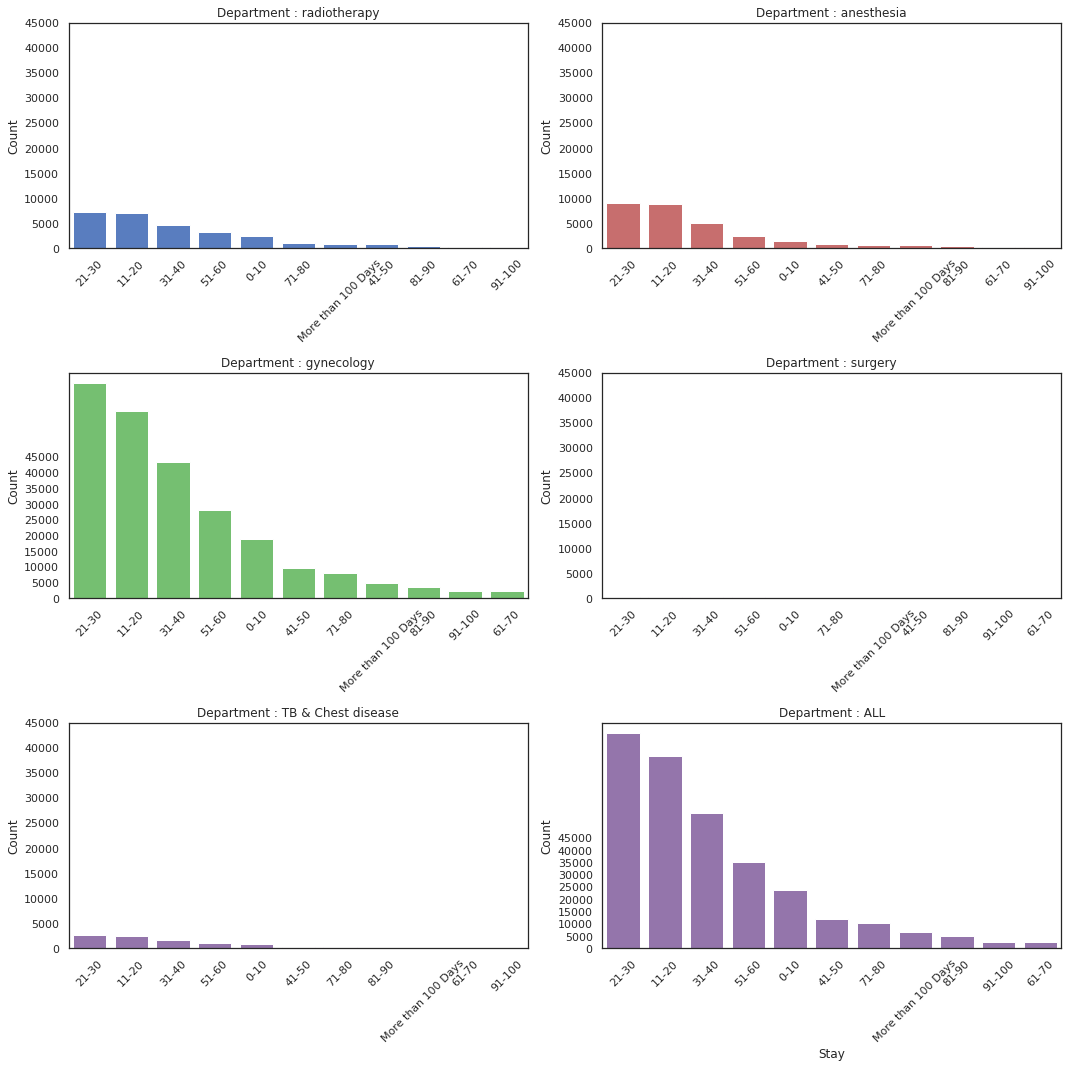

In [8]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 2, figsize=(15, 15))

radiotherapy = train_data[train_data.Department =='radiotherapy']["Stay"].value_counts().rename('Count')

anesthesia = train_data[train_data.Department =='anesthesia']["Stay"].value_counts().rename('Count')

gynecology = train_data[train_data.Department =='gynecology']["Stay"].value_counts().rename('Count')

surgery = train_data[train_data.Department =='surgery']["Stay"].value_counts().rename('Count')

tb = train_data[train_data.Department =='TB & Chest disease']["Stay"].value_counts().rename('Count')

sns.barplot(radiotherapy.index,radiotherapy,  color="b", ax=axes[0, 0]).set_title('Department : radiotherapy')

sns.barplot(anesthesia.index,anesthesia,   color="r", ax=axes[0, 1]).set_title('Department : anesthesia')

sns.barplot(gynecology.index,gynecology,  color="g", ax=axes[1, 0]).set_title('Department : gynecology')

sns.barplot(surgery.index,surgery, color="m", ax=axes[1, 1]).set_title('Department : surgery')

sns.barplot(tb.index,tb, color="m", ax=axes[2, 0]).set_title('Department : TB & Chest disease')

sns.barplot(stay.index,stay, color="m", ax=axes[2, 1]).set_title('Department : ALL')

plt.xlabel("Stay")

plt.setp(axes,yticks = np.arange(0,50000,5000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()


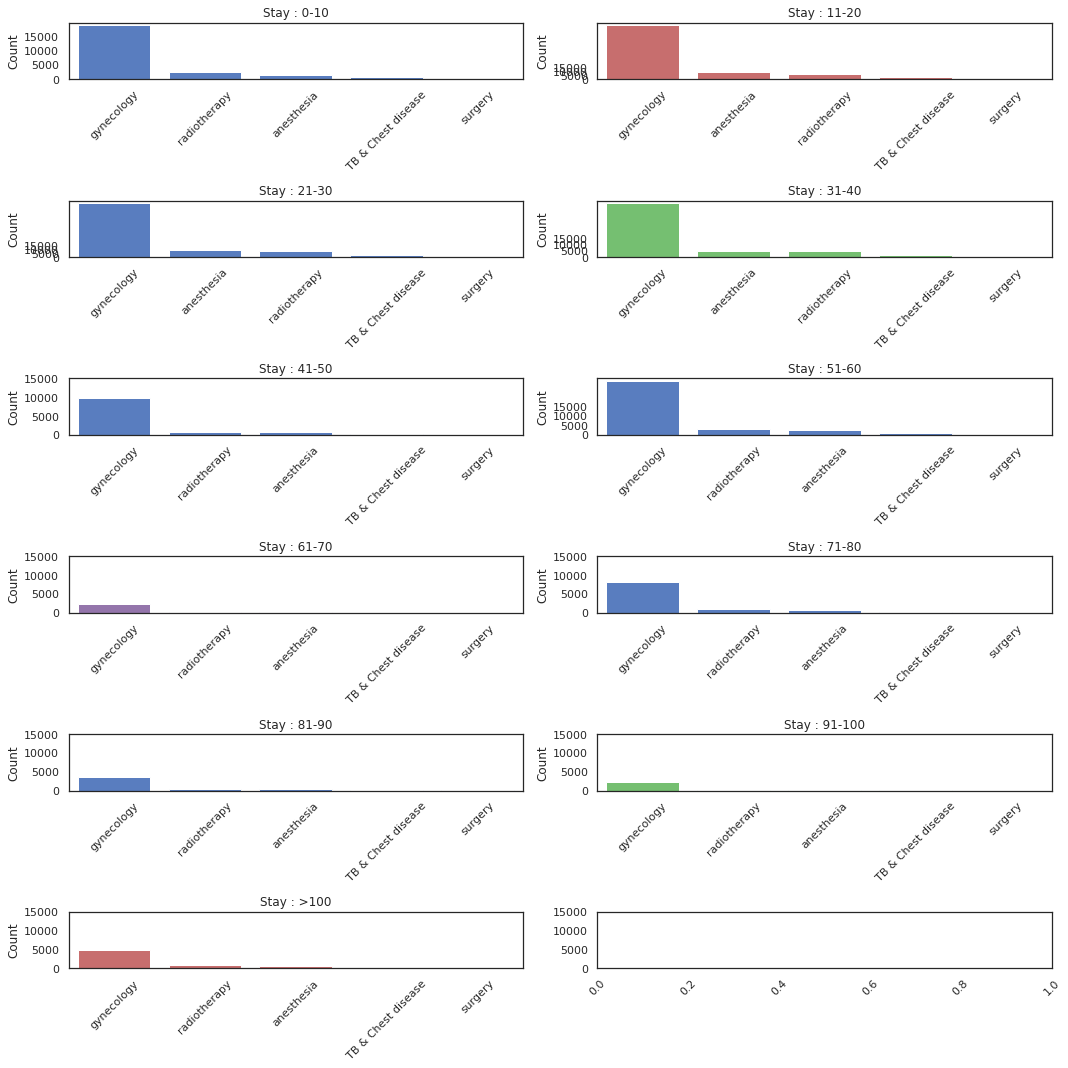

In [9]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(6, 2, figsize=(15, 15))

stay0 = train_data[train_data.Stay =='0-10']["Department"].value_counts().rename('Count')

stay1 = train_data[train_data.Stay =='11-20']["Department"].value_counts().rename('Count')

stay2 = train_data[train_data.Stay =='21-30']["Department"].value_counts().rename('Count')

stay3 = train_data[train_data.Stay =='31-40']["Department"].value_counts().rename('Count')

stay4 = train_data[train_data.Stay =='41-50']["Department"].value_counts().rename('Count')

stay5 = train_data[train_data.Stay =='51-60']["Department"].value_counts().rename('Count')

stay6 = train_data[train_data.Stay =='61-70']["Department"].value_counts().rename('Count')

stay7 = train_data[train_data.Stay =='71-80']["Department"].value_counts().rename('Count')

stay8 = train_data[train_data.Stay =='81-90']["Department"].value_counts().rename('Count')

stay9 = train_data[train_data.Stay =='91-100']["Department"].value_counts().rename('Count')

stay10 = train_data[train_data.Stay =='More than 100 Days']["Department"].value_counts().rename('Count')

sns.barplot(stay0.index,stay0,  color="b", ax=axes[0, 0]).set_title('Stay : 0-10')
                   
sns.barplot(stay1.index,stay2,  color="r", ax=axes[0, 1]).set_title('Stay : 11-20')

sns.barplot(stay2.index,stay2,  color="b", ax=axes[1, 0]).set_title('Stay : 21-30')

sns.barplot(stay3.index,stay3,  color="g", ax=axes[1, 1]).set_title('Stay : 31-40')

sns.barplot(stay4.index,stay4,  color="b", ax=axes[2, 0]).set_title('Stay : 41-50')

sns.barplot(stay5.index,stay5,  color="b", ax=axes[2, 1]).set_title('Stay : 51-60')

sns.barplot(stay6.index,stay6,  color="m", ax=axes[3, 0]).set_title('Stay : 61-70')

sns.barplot(stay7.index,stay7, color="b", ax=axes[3, 1]).set_title('Stay : 71-80')

sns.barplot(stay8.index,stay8,  color="b", ax=axes[4, 0]).set_title('Stay : 81-90')

sns.barplot(stay9.index,stay9,  color="g", ax=axes[4, 1]).set_title('Stay : 91-100')

sns.barplot(stay10.index,stay10, color="r", ax=axes[5, 0]).set_title('Stay : >100')

plt.setp(axes, yticks = np.arange(0,20000,5000))


for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()

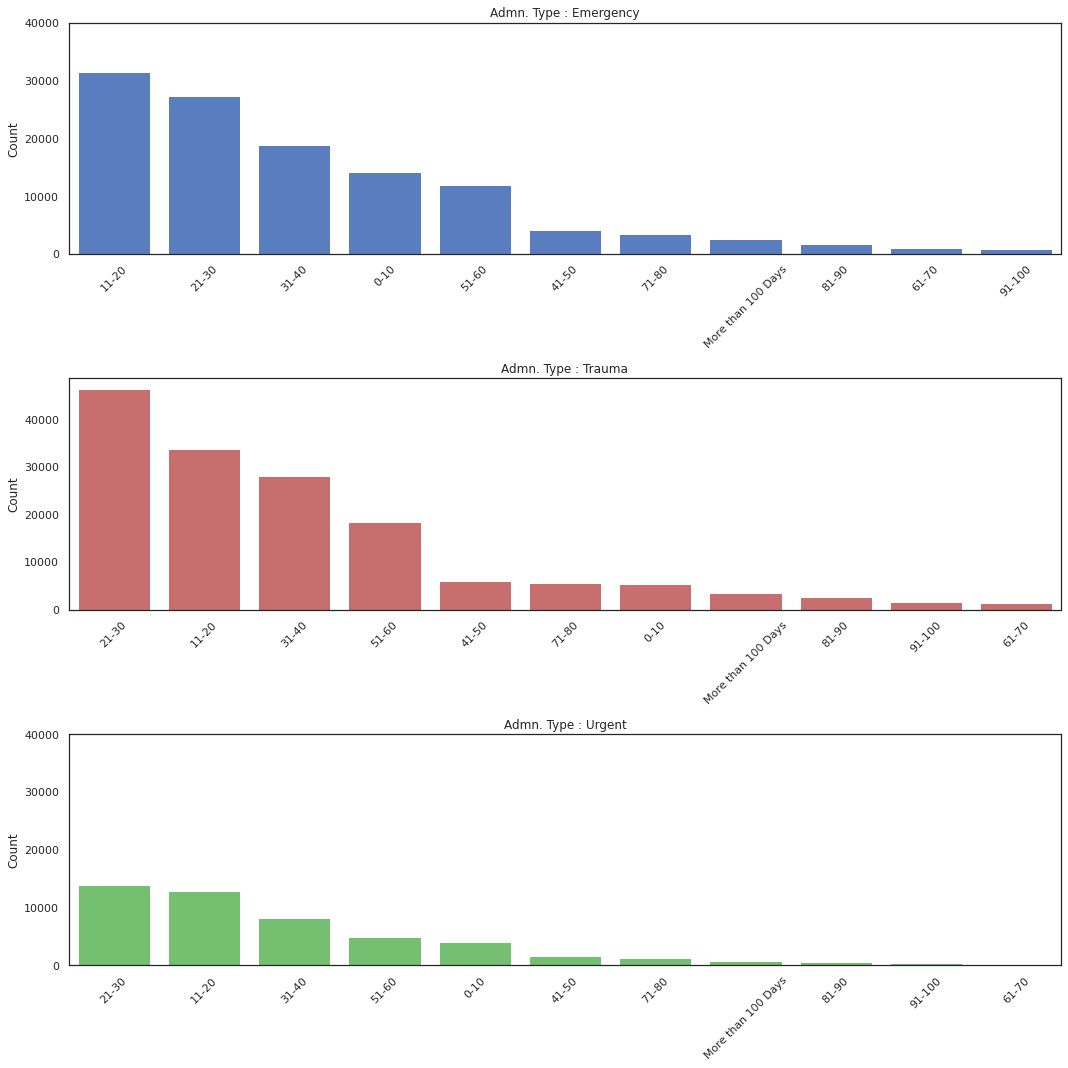

In [10]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(15, 15))

emergency = train_data[train_data['Type of Admission'] =='Emergency']["Stay"].value_counts().rename('Count')

trauma = train_data[train_data['Type of Admission'] =='Trauma']["Stay"].value_counts().rename('Count')

urgent = train_data[train_data['Type of Admission'] =='Urgent']["Stay"].value_counts().rename('Count')

sns.barplot(emergency.index,emergency,  color="b", ax=axes[0]).set_title('Admn. Type : Emergency')

sns.barplot(trauma.index,trauma,   color="r", ax=axes[1]).set_title('Admn. Type : Trauma')

sns.barplot(urgent.index,urgent,  color="g", ax=axes[2]).set_title('Admn. Type : Urgent')

plt.setp(axes, yticks = np.arange(0,50000,10000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()

In [11]:
train_data['City_Code_Patient'] = train_data['City_Code_Patient'].fillna(-1)
train_data['Bed Grade'] = train_data['Bed Grade'].fillna(-1)

In [12]:
test_data['City_Code_Patient'] = test_data['City_Code_Patient'].fillna(-1)
test_data['Bed Grade'] = test_data['Bed Grade'].fillna(-1)

In [13]:
cat_cols = ['Hospital_code','Hospital_type_code','City_Code_Hospital','Hospital_region_code'
            ,'Department','Ward_Type','Ward_Facility_Code','Bed Grade','City_Code_Patient',
           # 'Type of Admission','Severity of Illness',
            'Age']

In [14]:
label = 'Stay'

In [15]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        le = LabelEncoder()
        
        le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())
        
        train_df[col] = le.transform(train_df[[col]])
        
        test_df[col] = le.transform(test_df[[col]])

        le_dict[col] = le

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    train_df['Type of Admission'] = train_df['Type of Admission'].map({'Urgent':0,'Emergency':1,'Trauma':2})
    
    train_df['Severity of Illness'] = train_df['Severity of Illness'].map({'Minor':0,'Moderate':1,'Extreme':2})
    
    test_df['Type of Admission'] = test_df['Type of Admission'].map({'Urgent':0,'Emergency':1,'Trauma':2})
    
    test_df['Severity of Illness'] = test_df['Severity of Illness'].map({'Minor':0,'Moderate':1,'Extreme':2})
    
    return train_df, test_df, le_dict

In [16]:
def feature_importance(model, X_train):

    print(model.feature_importances_)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, model.feature_importances_)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

In [17]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_cols)

In [18]:
#After Feature Engineering
# https://www.kaggle.com/gcspkmdr/lets-get-rid-of-the-patients-feature-engineering

combined_data = pd.read_csv('../input/lets-get-rid-of-the-patients-feature-engineering/combined.csv')

In [19]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [20]:
train_df.drop(columns = ['case_id','train','patientid','Hospital_code',
                         'Hospital_type_code','City_Code_Hospital','Ward_Facility_Code'],inplace = True)

target = train_df.pop('Stay')

test_df.drop(columns = ['case_id','train','Stay','patientid','Hospital_code',
                        'Hospital_type_code','City_Code_Hospital','Ward_Facility_Code'],inplace = True)

# Cross Validation
![](https://4.bp.blogspot.com/-wpr6O3EBAfU/WbHyt6UCOVI/AAAAAAAAjPw/Y1DaO6qcV8oDYjJHzJ1PaPB2EXHmYtBBQCLcBGAs/s1600/%25E6%2593%25B7%25E5%258F%2596.JPG)

* **The CV score generated using the methodology shown in the above figure is a better indicator of model performance than public LB**

Fold 0
 rows of train = 175140 rows of holdout = 143298
[0]	validation_0-mlogloss:2.29854
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49394
[200]	validation_0-mlogloss:1.47933
[300]	validation_0-mlogloss:1.47553
Stopping. Best iteration:
[341]	validation_0-mlogloss:1.47517

XGB Val CV= 43.403257547209314
####################################################################################################
[0.00573478 0.01121851 0.00587288 0.04167959 0.01233892 0.00512549
 0.022717   0.01218187 0.0521452  0.00569408 0.00762324 0.00565972
 0.01119198 0.00594075 0.00587665 0.00469248 0.00532571 0.005015
 0.00506503 0.00536368 0.00517942 0.00494074 0.00483551 0.00555086
 0.00667649 0.00548493 0.00557201 0.00611857 0.01687059 0.00501652
 0.00575748 0.0085689  0.00883659 0.00727711 0.00517539 0.00605101
 0.00575978 0.00625469 0.03382934 0.05342815 0.04862951 0.01907245
 0.01676272 0.04698104 0.01049257 0.03998673 0.04890347 0.04666739
 0.0

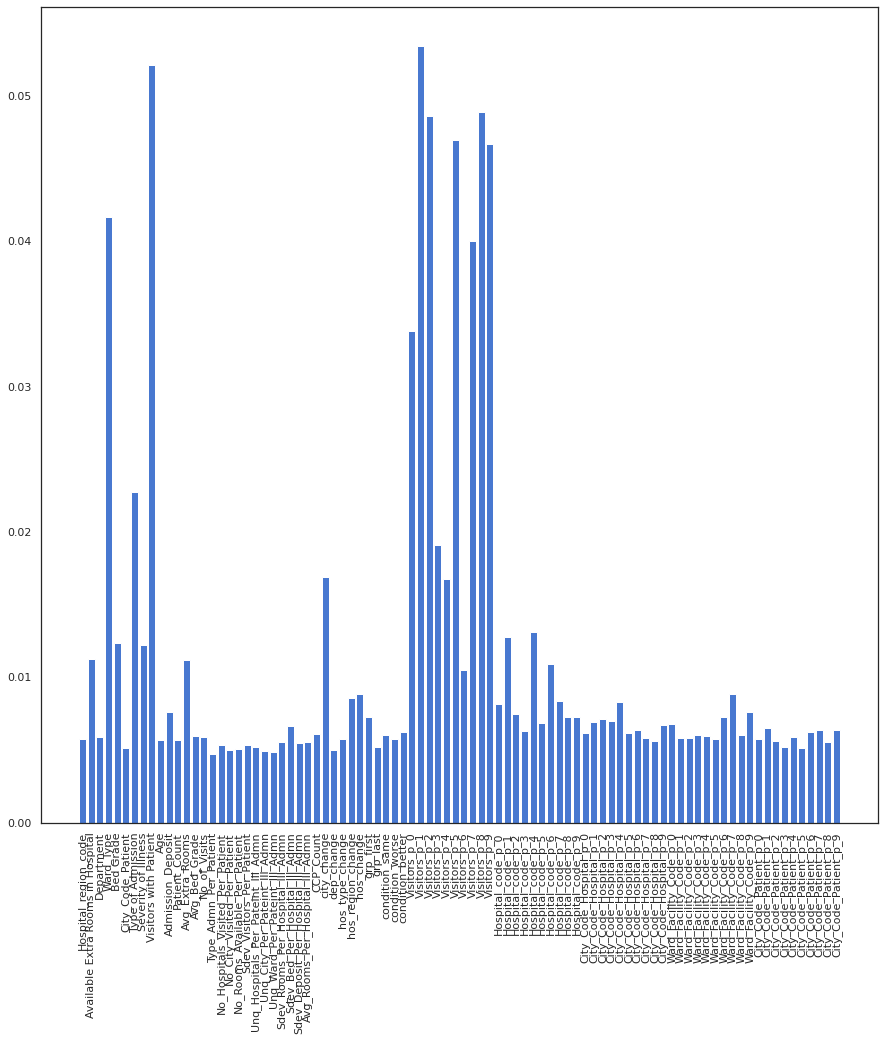

Fold 1
 rows of train = 175140 rows of holdout = 143298
[0]	validation_0-mlogloss:2.29824
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49418
[200]	validation_0-mlogloss:1.47931
[300]	validation_0-mlogloss:1.47534
[400]	validation_0-mlogloss:1.47503
Stopping. Best iteration:
[352]	validation_0-mlogloss:1.47492

XGB Val CV= 43.49607112450976
####################################################################################################
Fold 2
 rows of train = 175140 rows of holdout = 143298
[0]	validation_0-mlogloss:2.29826
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49211
[200]	validation_0-mlogloss:1.47760
[300]	validation_0-mlogloss:1.47400
Stopping. Best iteration:
[340]	validation_0-mlogloss:1.47372

XGB Val CV= 43.55678376530028
####################################################################################################
Fold 3
 rows of train = 175140 rows of hol

In [21]:
## %%time

##XGBM

scores = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.45 ,random_state=1)

for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):
    
    print('Fold',i)
    
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    
    clf = xgb.XGBClassifier(n_estimators=1000,
                            max_depth=6,
                            learning_rate=0.1,
                            subsample=0.8,
                            colsample_bytree=0.5,
                            tree_method ='gpu_hist'
                           )        
    
    
    h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                verbose=100,eval_metric='mlogloss',
                early_stopping_rounds=50)
    
    acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1))*100
    
    scores.append(acc)
    
    print ('XGB Val CV=',acc)
    
    print('#'*100)
    
    if i==0:
        feature_importance(clf,X_train_cv)

print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

# Model Building

In [22]:
trees = 5

seeds = [32,432,73]

submission = pd.read_csv('../input/healthcareanalyticsii/sample_submission.csv')

probs = np.zeros(shape=(len(test_df),11))

submission_probs = pd.DataFrame(columns = ['case_id'] + list(le_dict['Stay'].classes_))

submission_probs.iloc[:,0] = submission.iloc[:,0]

submission_probs.iloc[:,1:] = 0

In [23]:
%%time

##XgBoost

#groups = train_df['patientid'].values

scores = []

avg_loss = []

submission_name = [] 

X_train_cv,y_train_cv = train_df.copy(), target.copy()

for seed in tnrange(len(seeds)):

    sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.3 ,random_state=seeds[seed])

    for j, (idxT, idxV) in tqdm(enumerate(sssf.split(X_train_cv, y_train_cv))):

        print('Fold',j)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        model_xgb = [0] *trees

        for i in tnrange(trees):

            print('Tree',i)

            model_xgb[i] = xgb.XGBClassifier(n_estimators=1000,
                            max_depth=6,
                            learning_rate=0.1,
                            subsample=0.8,
                            colsample_bytree=0.5,
                            tree_method ='gpu_hist',
                            random_state = i*27
                           )        
    
    
            model_xgb[i].fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                verbose=100,eval_metric='mlogloss',
                early_stopping_rounds=50)
        
            probs_file_name = 'probs_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"
            
            submisssion_file_name  = 'submission_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"


            model_xgb_probs = model_xgb[i].predict_proba(test_df)
            
            submission_probs.iloc[:,1:] = model_xgb_probs
            
            # probablity file per seed per split per tree
            submission_probs.to_csv(probs_file_name,index = False)
            
            submission['Stay'] = le_dict['Stay'].inverse_transform(np.argmax(model_xgb_probs,axis =1))
            
            # submission file per seed per split per tree
            submission.to_csv(submisssion_file_name,index =False)
            
            probs += model_xgb_probs
            
            acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(model_xgb[i].predict_proba(X_train_cv.iloc[idxV]),axis =1))*100
            
            scores.append(acc)
            
            submission_name.append(submisssion_file_name)
            
            avg_loss.append(model_xgb[i].best_score)

            print ('XGB Accuracy Split =',acc)
            
            print('#'*100)
    

print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

Fold 0
 rows of train = 222906 rows of holdout = 95532


Tree 0
[0]	validation_0-mlogloss:2.29816
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49059
[200]	validation_0-mlogloss:1.47520
[300]	validation_0-mlogloss:1.47003
[400]	validation_0-mlogloss:1.46807
[500]	validation_0-mlogloss:1.46827
Stopping. Best iteration:
[451]	validation_0-mlogloss:1.46784

XGB Accuracy Split = 43.706820751161914
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29614
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49029
[200]	validation_0-mlogloss:1.47497
[300]	validation_0-mlogloss:1.46975
[400]	validation_0-mlogloss:1.46810
[500]	validation_0-mlogloss:1.46817
Stopping. Best iteration:
[466]	validation_0-mlogloss:1.46781

XGB Accuracy Split = 43.693212745467484
####################################################################################################
Tree 2
[0]	v

Tree 0
[0]	validation_0-mlogloss:2.29815
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49432
[200]	validation_0-mlogloss:1.47815
[300]	validation_0-mlogloss:1.47331
[400]	validation_0-mlogloss:1.47179
[500]	validation_0-mlogloss:1.47205
Stopping. Best iteration:
[457]	validation_0-mlogloss:1.47170

XGB Accuracy Split = 43.64087426202738
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29555
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49355
[200]	validation_0-mlogloss:1.47832
[300]	validation_0-mlogloss:1.47303
[400]	validation_0-mlogloss:1.47127
Stopping. Best iteration:
[425]	validation_0-mlogloss:1.47113

XGB Accuracy Split = 43.571787463886444
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29743
Will tra

Tree 0
[0]	validation_0-mlogloss:2.29792
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49149
[200]	validation_0-mlogloss:1.47583
[300]	validation_0-mlogloss:1.47080
[400]	validation_0-mlogloss:1.46943
Stopping. Best iteration:
[433]	validation_0-mlogloss:1.46924

XGB Accuracy Split = 43.7015869028179
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29575
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49133
[200]	validation_0-mlogloss:1.47582
[300]	validation_0-mlogloss:1.47080
[400]	validation_0-mlogloss:1.46946
[500]	validation_0-mlogloss:1.46944
Stopping. Best iteration:
[451]	validation_0-mlogloss:1.46918

XGB Accuracy Split = 43.71310136917473
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29711
Will train

Tree 0
[0]	validation_0-mlogloss:2.29812
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49052
[200]	validation_0-mlogloss:1.47463
[300]	validation_0-mlogloss:1.46943
[400]	validation_0-mlogloss:1.46778
Stopping. Best iteration:
[433]	validation_0-mlogloss:1.46774

XGB Accuracy Split = 43.524682828790354
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29601
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49005
[200]	validation_0-mlogloss:1.47459
[300]	validation_0-mlogloss:1.46929
[400]	validation_0-mlogloss:1.46757
[500]	validation_0-mlogloss:1.46781
Stopping. Best iteration:
[456]	validation_0-mlogloss:1.46743

XGB Accuracy Split = 43.579114851568065
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29672
Will tr

Tree 0
[0]	validation_0-mlogloss:2.29842
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49041
[200]	validation_0-mlogloss:1.47429
[300]	validation_0-mlogloss:1.46905
[400]	validation_0-mlogloss:1.46741
Stopping. Best iteration:
[431]	validation_0-mlogloss:1.46731

XGB Accuracy Split = 43.612611480969726
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29603
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.48915
[200]	validation_0-mlogloss:1.47345
[300]	validation_0-mlogloss:1.46893
[400]	validation_0-mlogloss:1.46710
Stopping. Best iteration:
[410]	validation_0-mlogloss:1.46707

XGB Accuracy Split = 43.616798559644934
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29695
Will train until validation_0-mlogloss hasn

Fold 0
 rows of train = 222906 rows of holdout = 95532


Tree 0
[0]	validation_0-mlogloss:2.29788
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49131
[200]	validation_0-mlogloss:1.47572
[300]	validation_0-mlogloss:1.47075
[400]	validation_0-mlogloss:1.46876
[500]	validation_0-mlogloss:1.46856
Stopping. Best iteration:
[454]	validation_0-mlogloss:1.46838

XGB Accuracy Split = 43.571787463886444
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29595
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49080
[200]	validation_0-mlogloss:1.47513
[300]	validation_0-mlogloss:1.47002
[400]	validation_0-mlogloss:1.46842
[500]	validation_0-mlogloss:1.46860
Stopping. Best iteration:
[452]	validation_0-mlogloss:1.46830

XGB Accuracy Split = 43.5466649918352
####################################################################################################
Tree 2
[0]	val

Tree 0
[0]	validation_0-mlogloss:2.29886
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49253
[200]	validation_0-mlogloss:1.47642
[300]	validation_0-mlogloss:1.47109
[400]	validation_0-mlogloss:1.46913
[500]	validation_0-mlogloss:1.46908
Stopping. Best iteration:
[461]	validation_0-mlogloss:1.46896

XGB Accuracy Split = 43.5466649918352
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29582
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49167
[200]	validation_0-mlogloss:1.47575
[300]	validation_0-mlogloss:1.47084
[400]	validation_0-mlogloss:1.46920
Stopping. Best iteration:
[438]	validation_0-mlogloss:1.46880

XGB Accuracy Split = 43.62517271699535
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29691
Will train

Tree 0
[0]	validation_0-mlogloss:2.29815
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.48959
[200]	validation_0-mlogloss:1.47310
[300]	validation_0-mlogloss:1.46764
[400]	validation_0-mlogloss:1.46551
Stopping. Best iteration:
[406]	validation_0-mlogloss:1.46541

XGB Accuracy Split = 43.686932127454675
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29575
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.48929
[200]	validation_0-mlogloss:1.47303
[300]	validation_0-mlogloss:1.46794
[400]	validation_0-mlogloss:1.46609
Stopping. Best iteration:
[394]	validation_0-mlogloss:1.46603

XGB Accuracy Split = 43.73403676255077
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29688
Will train until validation_0-mlogloss hasn'

Tree 0
[0]	validation_0-mlogloss:2.29831
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49155
[200]	validation_0-mlogloss:1.47615
[300]	validation_0-mlogloss:1.47170
[400]	validation_0-mlogloss:1.46986
Stopping. Best iteration:
[435]	validation_0-mlogloss:1.46959

XGB Accuracy Split = 43.53096344680317
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29587
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49210
[200]	validation_0-mlogloss:1.47652
[300]	validation_0-mlogloss:1.47166
[400]	validation_0-mlogloss:1.47026
Stopping. Best iteration:
[406]	validation_0-mlogloss:1.47019

XGB Accuracy Split = 43.45768956998702
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29731
Will train until validation_0-mlogloss hasn't

Tree 0
[0]	validation_0-mlogloss:2.29818
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49096
[200]	validation_0-mlogloss:1.47391
[300]	validation_0-mlogloss:1.46880
[400]	validation_0-mlogloss:1.46696
Stopping. Best iteration:
[427]	validation_0-mlogloss:1.46683

XGB Accuracy Split = 43.749738307582795
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29601
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49080
[200]	validation_0-mlogloss:1.47539
[300]	validation_0-mlogloss:1.46967
[400]	validation_0-mlogloss:1.46778
[500]	validation_0-mlogloss:1.46765
Stopping. Best iteration:
[473]	validation_0-mlogloss:1.46743

XGB Accuracy Split = 43.76543985261483
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29660
Will tra

Fold 0
 rows of train = 222906 rows of holdout = 95532


Tree 0
[0]	validation_0-mlogloss:2.29859
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49230
[200]	validation_0-mlogloss:1.47510
[300]	validation_0-mlogloss:1.46981
[400]	validation_0-mlogloss:1.46809
[500]	validation_0-mlogloss:1.46790
Stopping. Best iteration:
[512]	validation_0-mlogloss:1.46783

XGB Accuracy Split = 43.64506134070259
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29622
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49147
[200]	validation_0-mlogloss:1.47522
[300]	validation_0-mlogloss:1.46987
[400]	validation_0-mlogloss:1.46757
[500]	validation_0-mlogloss:1.46719
Stopping. Best iteration:
[462]	validation_0-mlogloss:1.46704

XGB Accuracy Split = 43.6502951890466
####################################################################################################
Tree 2
[0]	vali

Tree 0
[0]	validation_0-mlogloss:2.29815
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49196
[200]	validation_0-mlogloss:1.47586
[300]	validation_0-mlogloss:1.47069
[400]	validation_0-mlogloss:1.46903
Stopping. Best iteration:
[441]	validation_0-mlogloss:1.46884

XGB Accuracy Split = 43.448268642967804
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29641
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49130
[200]	validation_0-mlogloss:1.47554
[300]	validation_0-mlogloss:1.47046
[400]	validation_0-mlogloss:1.46825
Stopping. Best iteration:
[418]	validation_0-mlogloss:1.46815

XGB Accuracy Split = 43.45768956998702
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29698
Will train until validation_0-mlogloss hasn'

Tree 0
[0]	validation_0-mlogloss:2.29846
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49162
[200]	validation_0-mlogloss:1.47620
[300]	validation_0-mlogloss:1.47121
[400]	validation_0-mlogloss:1.46998
[500]	validation_0-mlogloss:1.47023
Stopping. Best iteration:
[459]	validation_0-mlogloss:1.46964

XGB Accuracy Split = 43.51212159276473
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29596
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49143
[200]	validation_0-mlogloss:1.47612
[300]	validation_0-mlogloss:1.47105
[400]	validation_0-mlogloss:1.46968
Stopping. Best iteration:
[405]	validation_0-mlogloss:1.46962

XGB Accuracy Split = 43.49223296905749
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29679
Will trai

Tree 0
[0]	validation_0-mlogloss:2.29804
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.48693
[200]	validation_0-mlogloss:1.47079
[300]	validation_0-mlogloss:1.46619
[400]	validation_0-mlogloss:1.46470
[500]	validation_0-mlogloss:1.46489
Stopping. Best iteration:
[461]	validation_0-mlogloss:1.46458

XGB Accuracy Split = 43.92245530293514
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29602
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.48688
[200]	validation_0-mlogloss:1.47074
[300]	validation_0-mlogloss:1.46564
[400]	validation_0-mlogloss:1.46408
[500]	validation_0-mlogloss:1.46411
Stopping. Best iteration:
[464]	validation_0-mlogloss:1.46387

XGB Accuracy Split = 43.82824603274295
####################################################################################################
Tree 2
[0]	val

Tree 0
[0]	validation_0-mlogloss:2.29854
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49405
[200]	validation_0-mlogloss:1.47772
[300]	validation_0-mlogloss:1.47234
[400]	validation_0-mlogloss:1.47090
Stopping. Best iteration:
[441]	validation_0-mlogloss:1.47067

XGB Accuracy Split = 43.547711761504
####################################################################################################
Tree 1
[0]	validation_0-mlogloss:2.29633
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:1.49366
[200]	validation_0-mlogloss:1.47761
[300]	validation_0-mlogloss:1.47223
[400]	validation_0-mlogloss:1.47047
Stopping. Best iteration:
[444]	validation_0-mlogloss:1.47043

XGB Accuracy Split = 43.65971611606582
####################################################################################################
Tree 2
[0]	validation_0-mlogloss:2.29677
Will train until validation_0-mlogloss hasn't i

In [24]:
submission_probs.iloc[:,1:] = probs

# probablity combined
submission_probs.to_csv('probs.csv',index =False)

In [25]:
submission['Stay'] = le_dict['Stay'].inverse_transform(np.argmax(probs,axis =1))

# submission file combined            
submission.to_csv('submission.csv',index =False)
            

In [26]:
model_stats = pd.DataFrame({'submission':submission_name,'accuracy':scores,'validation_loss':avg_loss})
model_stats.head()

,submission,accuracy,validation_loss
0,submission_32_0_0.csv,43.706821,1.467838
1,submission_32_0_1.csv,43.693213,1.467809
2,submission_32_0_2.csv,43.715195,1.467464
3,submission_32_0_3.csv,43.718335,1.467625
4,submission_32_0_4.csv,43.746598,1.468157


In [27]:
model_stats.to_csv('model_stats.csv',index =False)